In [1]:
# %matplotlib ipympl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [2]:
import math

from common import *
from experiment import *
from data import DirectRawData, PlottableData

In [3]:
TREATMENTS = [
    TCPTreatment(cca='cubic', pep=False),
    TCPTreatment(cca='bbr', pep=False, label='tcp_bbr'),
    TCPTreatment(cca='bbr', pep=False, label='tcp_bbr1'),  # When the default bbr module on the current Linux kernel is v1!
    QUICTreatment(cca='cubic'),
    QUICTreatment(cca='bbr'),
    QUICTreatment(cca='bbr1'),
]
TCP_CUBIC = TREATMENTS[0]
TCP_BBRV3 = TREATMENTS[1]
TCP_BBRV1 = TREATMENTS[2]
QUIC_CUBIC = TREATMENTS[3]
QUIC_BBRV3 = TREATMENTS[4]
QUIC_BBRV1 = TREATMENTS[5]

# Plotting functions to execute parameter space for each CCA

In [4]:
# Plot function
def plot_3d_heatmap(data, xs, ys, zs):
    assert len(data.treatments) == 1
    treatment = data.treatments[0]
    loss  = {x: i for i, x in enumerate(xs)}
    delay = {y: j for j, y in enumerate(ys)}
    bw    = {z: k for k, z in enumerate(zs)}
    x, y, z = np.meshgrid(xs, ys, zs)

    # Flatten the grid for easier plotting
    x = x.flatten()
    y = y.flatten()
    z = z.flatten()

    # Assign a heatmap value to each point
    # The goodput as a proportion of bottleneck bandwidth
    subdata = data.data[treatment]
    final_x = []
    final_y = []
    final_z = []
    final_values = []
    to_3d_index = lambda i, j, k: i*len(bw) + j*len(loss)*len(bw) + k
    for network_setting in data.exp.get_network_settings():
        network_data = subdata[network_setting.label()]
        if len(network_data) == 0:
            continue
        assert len(network_data) == 1

        # Calculate the index for the 3D point
        i = loss[network_setting.get('loss1')]
        j = delay[network_setting.get('delay1')]
        k = bw[network_setting.get('bw1')]
        index = to_3d_index(i, j, k)

        # Calculate and set the value for that point
        goodput = next(iter(network_data.values())).mean
        value = goodput / network_setting.get('bw1')
        final_x.append(float(x[index]))
        final_y.append(y[index])
        final_z.append(z[index])
        final_values.append(value)

        # Log the values at the edge of each dimension
        if i in [0, len(xs)-1] and j in [0, len(ys)-1] and k in [0, len(zs)-1]:
            print(f'({xs[i]},\t{ys[j]},\t{zs[k]})\t-> {value:.3f}')
    
    # Plot the 3D heatmap
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot with colormap
    sc = ax.scatter(final_x, final_y, final_z, c=final_values,
        cmap='viridis', s=50, alpha=0.8, vmin=0, vmax=1)

    # Add color bar for the heatmap
    cbar = fig.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
    cbar.set_label('Thoughput / Bandwidth')
    
    # Add axis labels
    ax.set_xlabel('Loss')
    ax.set_ylabel('Delay')
    ax.set_zlabel('Bandwidth')
    ax.set_title(treatment)
    
    # Enable rotation
    # ax.view_init(elev=20, azim=30)  # Set initial viewing angles
    # plt.ion()  # Turn on interactive mode
    plt.show()

    # Keep the plot open in interactive mode
    # input("Press Enter to exit and close the plot.")

In [5]:
# Plot function
def plot_2d_heatmap(data, xs, ys, bw):
    assert len(data.treatments) == 1
    treatment = data.treatments[0]
    loss  = {x: i for i, x in enumerate(xs)}
    delay = {y: j for j, y in enumerate(ys)}

    # Prepare the heatmap values
    heatmap_values = np.zeros((len(ys), len(xs)))
    subdata = data.data[treatment]

    for network_setting in data.exp.get_network_settings():
        network_data = subdata[network_setting.label()]
        if len(network_data) == 0:
            continue
        assert len(network_data) == 1

        # Check if the setting matches the fixed bw
        if network_setting.get('bw1') != bw:
            continue

        # Calculate the indexes for the network setting
        i = loss[network_setting.get('loss1')]
        j = delay[network_setting.get('delay1')]

        # Calculate and set the value for that point
        goodput = next(iter(network_data.values())).mean
        value = goodput / bw
        heatmap_values[j, i] = value
    
    # Plot the 2D heatmap
    fig, ax = plt.subplots(figsize=(4, 3))
    xs = list(map(float, xs))
    cax = ax.imshow(
        heatmap_values, 
        cmap='viridis', 
        origin='lower', 
        extent=[min(xs), max(xs), min(ys), max(ys)], 
        aspect='auto', 
        vmin=0, 
        vmax=1
    )

    # Add labels to each square
    x_step = (max(xs) - min(xs)) / (len(xs))
    y_step = (max(ys) - min(ys)) / (len(ys))
    for j in range(len(ys)):
        for i in range(len(xs)):
            value = heatmap_values[j, i]
            ax.text(
                min(xs) + (i+0.5) * x_step, 
                min(ys) + (j+0.5) * y_step, 
                f'{value:.2f}', 
                ha='center', va='center', color='white', 
                fontsize=8
            )

    # Add color bar for the heatmap
    cbar = fig.colorbar(cax, ax=ax)
    cbar.set_label('Thoughput / Bandwidth')
    
    # Add axis labels
    ax.set_xlabel('Loss')
    ax.set_ylabel('Delay')
    ax.set_title(f'{treatment} - bandwidth {bw}Mbit/s')
    plt.show()

In [6]:
def run_experiment_and_plot_heatmaps(treatment, loss, delay, bw, timeout=180, execute=False, num_trials=1, max_retries=10):
    data_size = lambda bw: int(10*1000000*bw/8)  # 10x the bottleneck bandwidth
    loss = list(map(str, loss))

    # Create experiment
    exp = Experiment(
        num_trials, [treatment], [], [],
        network_losses=loss,
        network_delays=delay,
        network_bws=bw,
        timeout=timeout,
        cartesian=False,
    )
    raw_data = DirectRawData(exp, execute=execute, max_retries=max_retries)

    # Plot data
    metric = 'throughput_mbps'
    plottable_data = PlottableData(raw_data, metric=metric)
    plot_3d_heatmap(plottable_data, xs=loss, ys=delay, zs=bw)
    fixed_bws = [bw[0], bw[int((len(bw)-1)/2)], bw[-1]]
    for fixed_bw in fixed_bws:
        plot_2d_heatmap(plottable_data, xs=loss, ys=delay, bw=fixed_bw)

# BBRv3

(0,	1,	10)	-> 0.953
(0,	1,	500)	-> 0.914
(0,	100,	10)	-> 0.818
(0,	100,	500)	-> 0.555
(4,	1,	10)	-> 0.830
(4,	1,	500)	-> 0.540
(4,	100,	10)	-> 0.574


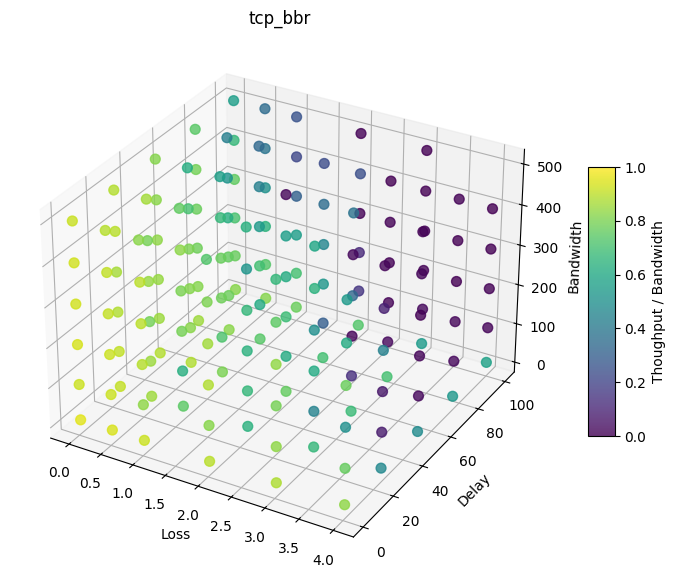

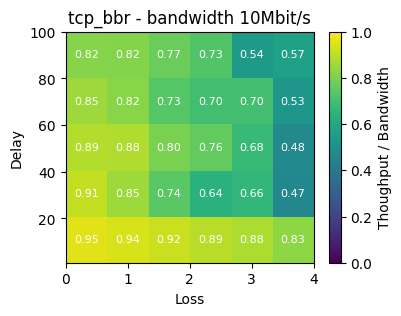

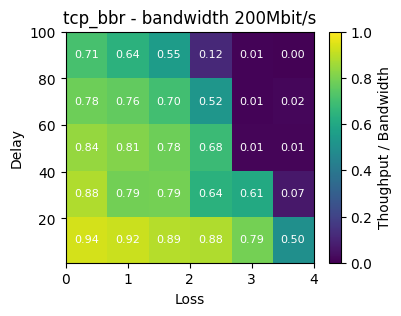

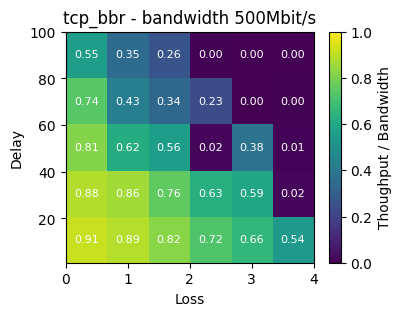

In [7]:
run_experiment_and_plot_heatmaps(
    treatment=TCP_BBRV3,
    loss=[0, 0.5, 1, 2, 3, 4],
    delay=[1, 25, 50, 75, 100], #, 150, 200, 250]
    bw=[10, 100, 200, 300, 400, 500], #, 1000]
    execute=True,
)

(0,	1,	10)	-> 0.946
(0,	1,	500)	-> 0.155
(0,	100,	10)	-> 0.881
(0,	100,	500)	-> 0.139
(4,	1,	10)	-> 0.945
(4,	1,	500)	-> 0.114
(4,	100,	10)	-> 0.730


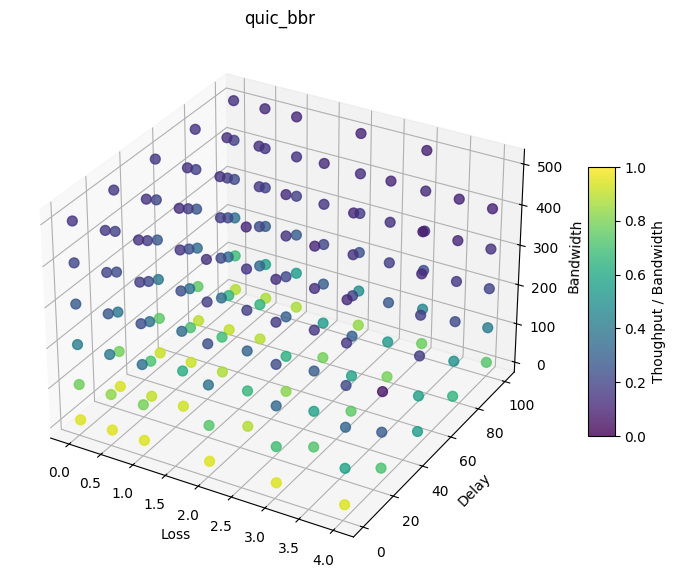

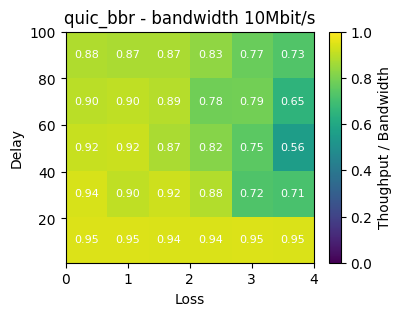

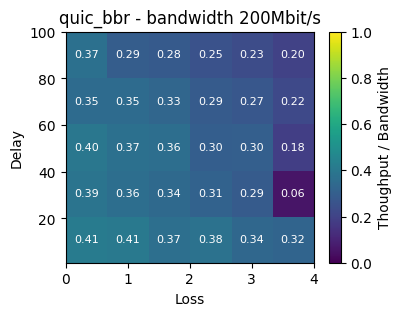

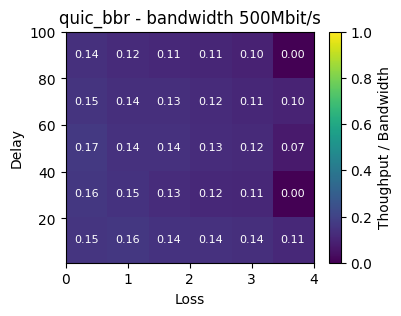

In [8]:
run_experiment_and_plot_heatmaps(
    treatment=QUIC_BBRV3,
    loss=[0, 0.5, 1, 2, 3, 4],
    delay=[1, 25, 50, 75, 100],
    bw=[10, 100, 200, 300, 400, 500],
    execute=True,
)

# BBRv1

(0,	1,	10)	-> 0.946
(0,	1,	500)	-> 0.162
(0,	100,	10)	-> 0.854
(0,	100,	500)	-> 0.142
(4,	1,	10)	-> 0.943
(4,	1,	500)	-> 0.134
(4,	100,	10)	-> 0.837
(4,	100,	500)	-> 0.089


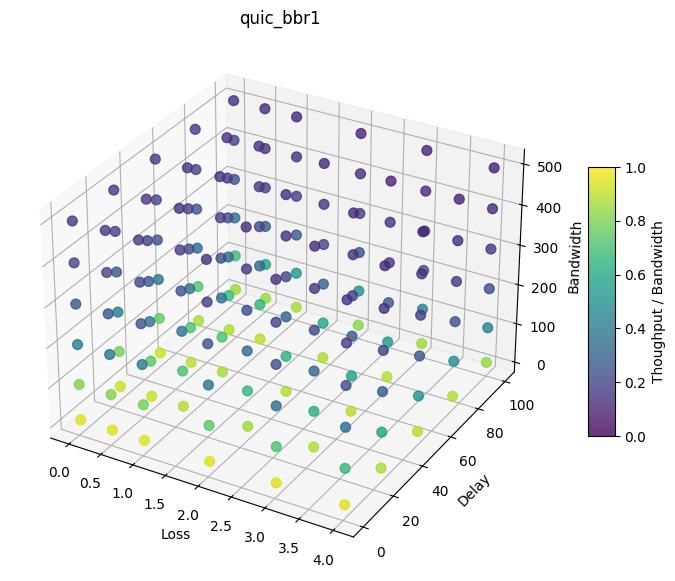

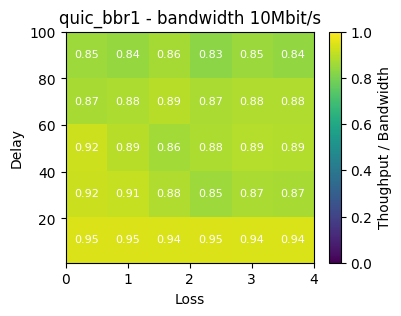

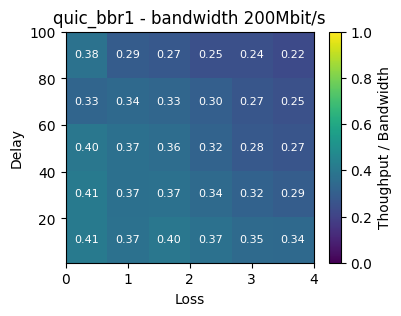

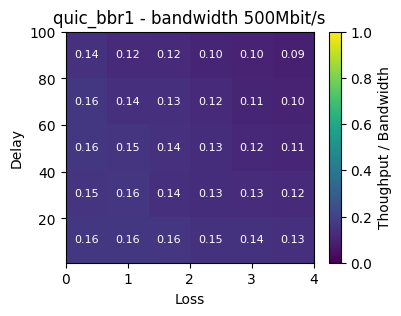

In [9]:
run_experiment_and_plot_heatmaps(
    treatment=QUIC_BBRV1,
    loss=[0, 0.5, 1, 2, 3, 4],
    delay=[1, 25, 50, 75, 100],
    bw=[10, 100, 200, 300, 400, 500],
    execute=True,
)

(0,	1,	10)	-> 0.954
(0,	1,	500)	-> 0.934
(0,	100,	10)	-> 0.834
(0,	100,	500)	-> 0.553
(4,	1,	10)	-> 0.954
(4,	1,	500)	-> 0.882
(4,	100,	10)	-> 0.728
(4,	100,	500)	-> 0.189


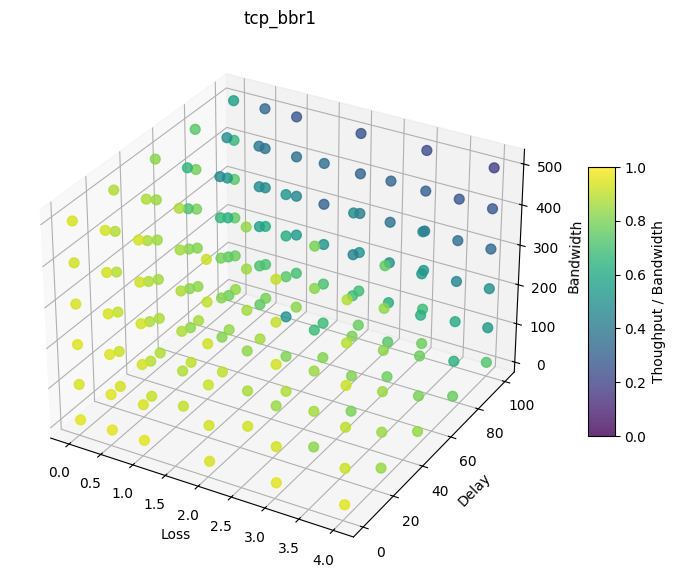

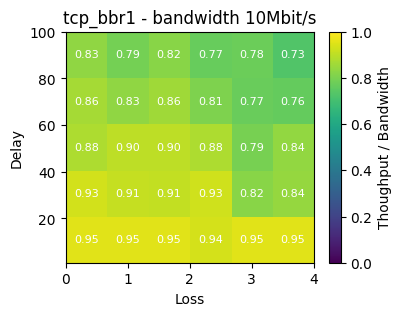

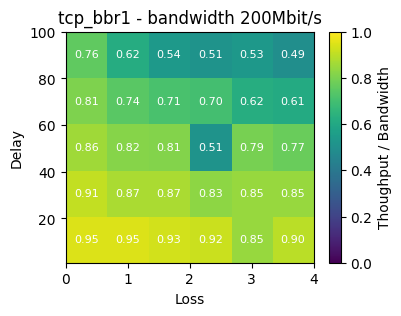

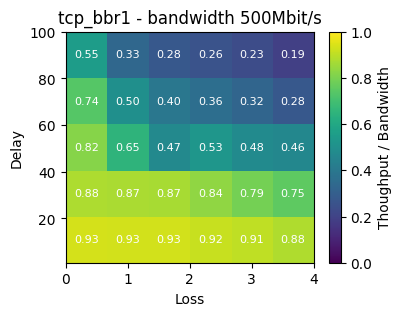

In [10]:
run_experiment_and_plot_heatmaps(
    treatment=TCP_BBRV1,
    loss=[0, 0.5, 1, 2, 3, 4],
    delay=[1, 25, 50, 75, 100],
    bw=[10, 100, 200, 300, 400, 500],
    execute=True,
    max_retries=12,
)

# CUBIC

(0,	1,	10)	-> 0.954
(0,	1,	500)	-> 0.948
(0,	100,	10)	-> 0.839
(0,	100,	500)	-> 0.570
(1,	1,	10)	-> 0.898
(1,	1,	500)	-> 0.540
(1,	100,	10)	-> 0.118


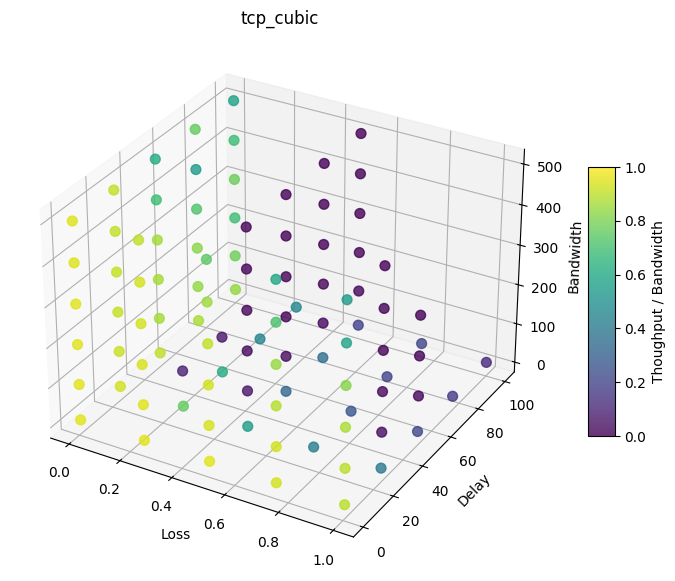

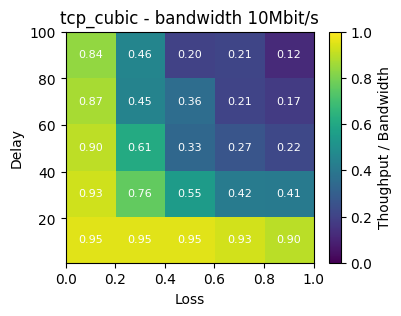

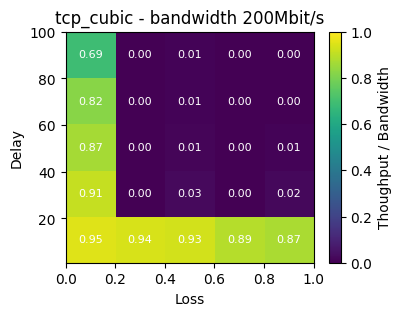

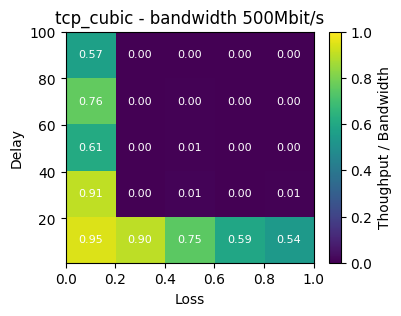

In [11]:
run_experiment_and_plot_heatmaps(
    treatment=TCP_CUBIC,
    loss=[0, 0.25, 0.5, 0.75, 1],
    delay=[1, 25, 50, 75, 100],
    bw=[10, 100, 200, 300, 400, 500],
    execute=True,
)

(0,	1,	10)	-> 0.946
(0,	1,	500)	-> 0.162
(0,	100,	10)	-> 0.904
(0,	100,	500)	-> 0.143
(1,	1,	10)	-> 0.946
(1,	1,	500)	-> 0.138
(1,	100,	10)	-> 0.125


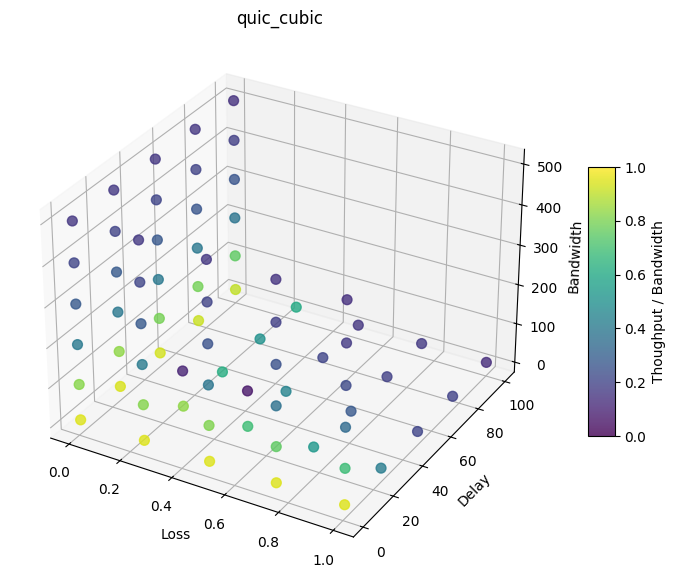

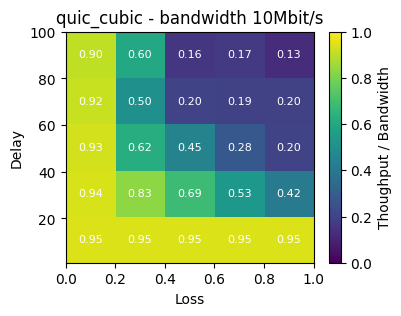

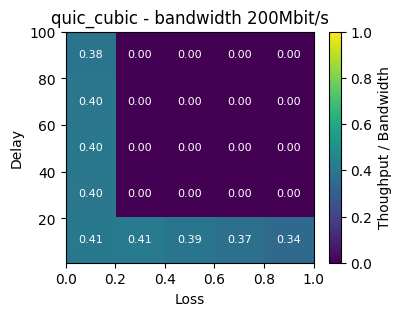

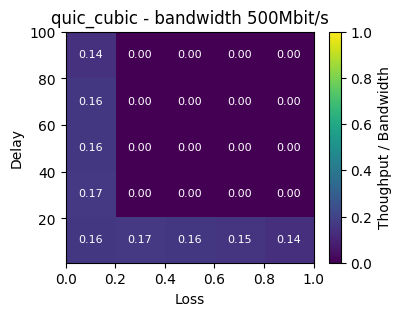

In [12]:
run_experiment_and_plot_heatmaps(
    treatment=QUIC_CUBIC,
    loss=[0, 0.25, 0.5, 0.75, 1],
    delay=[1, 25, 50, 75, 100],
    bw=[10, 100, 200, 300, 400, 500],
    execute=True,
)